In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [11]:
atr_period = 10
multiplier = 3.0

In [7]:
symbol = 'AAPL'
df = yf.download(symbol, start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [8]:
high = df['High']
low = df['Low']
close = df['Close']

# ATR Calculation

In [9]:
# calculate ATR
price_diffs = [high - low, 
                high - close.shift(), 
                close.shift() - low]
true_range = pd.concat(price_diffs, axis=1)
true_range = true_range.abs().max(axis=1)
# default ATR calculation in supertrend indicator
atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean()

In [12]:
# HL2 is simply the average of high and low prices
hl2 = (high + low) / 2
# upperband and lowerband calculation
# notice that final bands are set to be equal to the respective bands
final_upperband = upperband = hl2 + (multiplier * atr)
final_lowerband = lowerband = hl2 - (multiplier * atr)

# Adjustment we need to make to the upper and lower bands to form the final bands

In [14]:
# initialize Supertrend column to True
supertrend = [True] * len(df)

for i in range(1, len(df.index)):
    curr, prev = i, i-1
    
    # if current close price crosses above upperband
    if close[curr] > final_upperband[prev]:
        supertrend[curr] = True
    # if current close price crosses below lowerband
    elif close[curr] < final_lowerband[prev]:
        supertrend[curr] = False
    # else, the trend continues
    else:
        supertrend[curr] = supertrend[prev]
        
        # adjustment to the final bands
        if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
            final_lowerband[curr] = final_lowerband[prev]
        if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
            final_upperband[curr] = final_upperband[prev]

    # to remove bands according to the trend direction
    if supertrend[curr] == True:
        final_upperband[curr] = np.nan
    else:
        final_lowerband[curr] = np.nan

In [17]:
supertrend = pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)

In [18]:
df = df.join(supertrend)

# Visualization

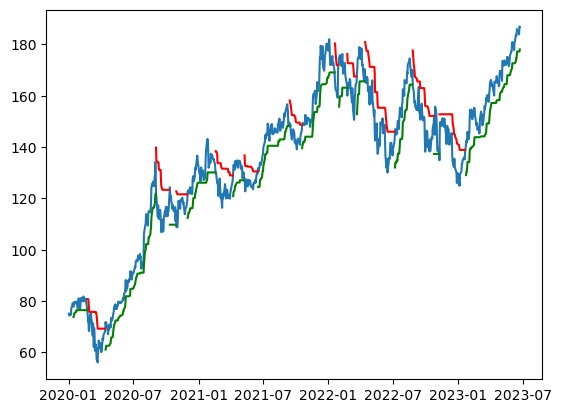

In [19]:
# visualization
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

# Backtesting

### Enter when the price movement is in the uptrend and exit when the trend direction changes.

In [20]:
investment = 100000
is_uptrend = df['Supertrend']
close = df['Close']

# initial condition
in_position = False
equity = investment
commission = 5
share = 0
entry = []
exit = []

In [21]:
for i in range(2, len(df)):
    # if not in position & price is on uptrend -> buy
    if not in_position and is_uptrend[i]:
        share = math.floor(equity / close[i] / 100) * 100
        equity -= share * close[i]
        entry.append((i, close[i]))
        in_position = True
        print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if in position & price is not on uptrend -> sell
    elif in_position and not is_uptrend[i]:
        equity += share * close[i] - commission
        exit.append((i, close[i]))
        in_position = False
        print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')


Buy 1300 shares at 74.95 on 2020/01/06
Sell at 74.54 on 2020/02/24
Buy 1300 shares at 71.76 on 2020/04/14
Sell at 120.88 on 2020/09/03
Buy 1300 shares at 124.4 on 2020/10/12
Sell at 108.86 on 2020/10/30
Buy 1100 shares at 122.72 on 2020/12/01
Sell at 129.71 on 2021/02/18
Buy 1100 shares at 130.36 on 2021/04/08
Sell at 126.85 on 2021/05/10
Buy 1100 shares at 131.79 on 2021/06/17
Sell at 148.12 on 2021/09/14
Buy 1100 shares at 148.76 on 2021/10/19
Sell at 166.23 on 2022/01/19
Buy 1000 shares at 174.78 on 2022/01/31
Sell at 160.07 on 2022/02/23
Buy 1000 shares at 168.82 on 2022/03/22
Sell at 165.29 on 2022/04/14
Buy 1100 shares at 146.35 on 2022/07/07
Sell at 163.62 on 2022/08/26
Buy 1200 shares at 152.34 on 2022/10/25
Sell at 134.87 on 2022/11/09
Buy 1100 shares at 141.11 on 2023/01/23


In [22]:
# if still in position -> sell all share 
if in_position:
    equity += share * close[i] - commission

earning = equity - investment
roi = round(earning/investment*100,2)
print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')

Earning from investing $100k is $113992.23 (ROI = 113.99%)
